In [379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC

In [380]:
facecolour = '#FFFFFF'
axiscolour = '#000000'
secondarycolour = '#0000FF'
tertiarycolour = '#ff0000'

def color_axis(ax, facecolour=facecolour, axiscolour=axiscolour):
    ax.spines['bottom'].set_color(axiscolour)
    ax.spines['top'].set_color(facecolour)
    ax.spines['left'].set_color(axiscolour)
    ax.spines['right'].set_color(facecolour)
    ax.tick_params(axis='x',colors=axiscolour)
    ax.tick_params(axis='y',colors=axiscolour)
    ax.xaxis.label.set_color(axiscolour)
    ax.yaxis.label.set_color(axiscolour)
    return ax

In [381]:
data = pd.read_csv('final_dataset.csv', low_memory=False)

In [382]:
data.shape

(63594, 260)

In [383]:
time = data.pop('adj_round')

In [384]:
data.drop(['Unnamed: 0','Unnamed: 0.1',
 'Unnamed: 0.1.1',
 'Unnamed: 0.1.1.1', 'key_0'], axis=1, inplace=True)

If a team is not in the test set (2018/19 season) then they will not help predictions and so should be dropped.

Good bye : HUL STO MID WBA SUN SWA

In [385]:
data.drop(['HUL', 'STO', 'MID',
          'WBA', 'SUN', 'SWA'], axis=1, inplace=True)

There are some duplicates created along the way.

In [386]:
data.drop(['player.1','round.1'], axis=1, inplace=True)

Dont want player as feature

In [387]:
data.drop('player', axis=1, inplace=True)

Need to dummify team, next team and position features. 

In [388]:
data=pd.get_dummies(data, columns=['team', 'next_team', 'position'])

Form is constant over players due to scrape only getting most recent week form, no form data for ealier seasons. The same goes for report. Not sure how it got this far without being dropped.

In [389]:
data.drop(['form','report'],axis=1,inplace=True)

Ordering features by their variation

In [390]:
feature_var=data.var().sort_values(ascending=False)
feature_var_log=feature_var.apply(lambda x: np.log(x))

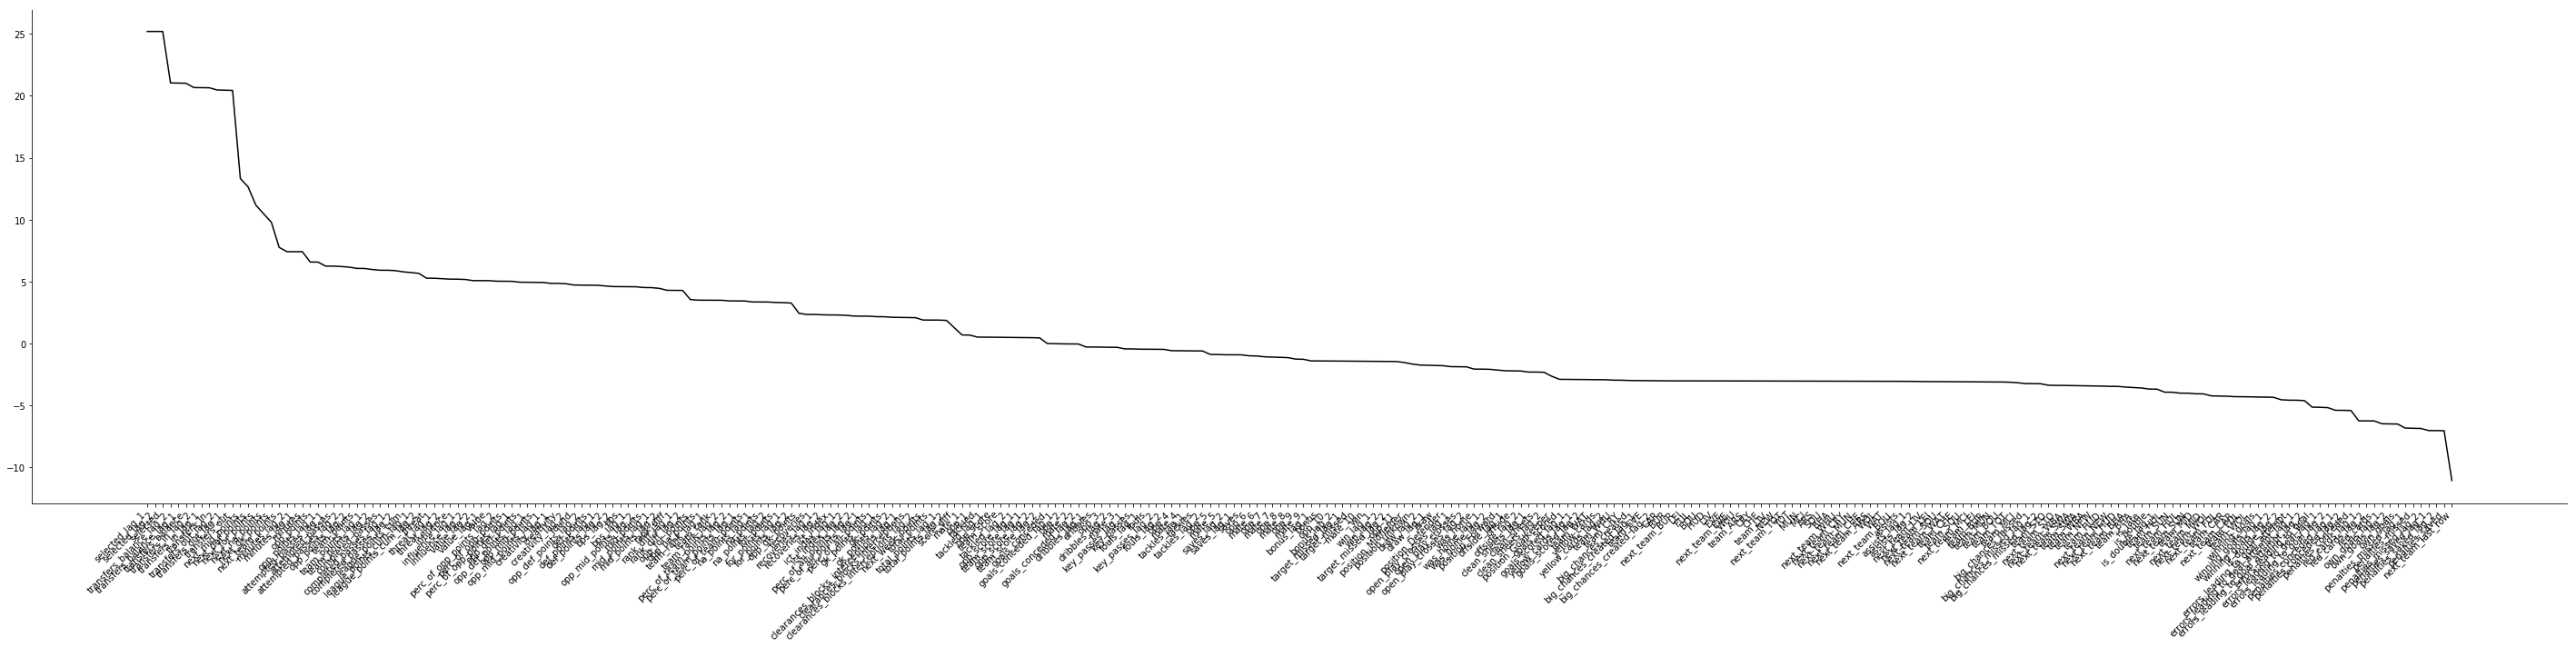

In [391]:
fig,ax=plt.subplots(figsize=(50,10))
sns.lineplot(data=feature_var_log.sort_values(ascending=False),
            sort=False, color=axiscolour, ax=ax)

ax=color_axis(ax)

plt.xticks(rotation=45, ha='right')
plt.savefig('feature_vars.png', facecolor=facecolour)

On the most part, annoyingly, low variation features tend to be those that are intuitively the best explainers of points, such as team playing next week. For this reason i'm not dropping any features from this method expect next_team_last_row, which was a filler anyway.

In [392]:
data.drop('next_team_last_row', axis=1, inplace=True)

Hunting for Multicollinearity

In [393]:
corrmat=data.corr()

In [394]:
target_corr=corrmat.pop('next_week_points')

In [395]:
pairs=[]
for col in corrmat.columns:
    tmp=corrmat[col]
    pairs_with=tmp[tmp>0.8]
    pairs_tup=[]
    for pair in pairs_with.index:
        if pair==col:
            continue
        elif (pair, col) in pairs:
            continue
        else:
            pairs_tup.append((col,pair))
    pairs.extend(pairs_tup)
print(pairs)

[('attempted_passes', 'completed_passes'), ('attempted_passes', 'minutes'), ('attempted_passes_lag_1', 'completed_passes_lag_1'), ('attempted_passes_lag_1', 'minutes_lag_1'), ('attempted_passes_lag_2', 'completed_passes_lag_2'), ('attempted_passes_lag_2', 'minutes_lag_2'), ('bps', 'influence'), ('bps', 'perc_of_all_points'), ('bps', 'perc_of_team_points'), ('bps', 'total_points'), ('bps_lag_1', 'influence_lag_1'), ('bps_lag_1', 'perc_of_all_points_lag_1'), ('bps_lag_1', 'perc_of_team_points_lag_1'), ('bps_lag_1', 'total_points_lag_1'), ('bps_lag_2', 'influence_lag_2'), ('bps_lag_2', 'perc_of_all_points_lag_2'), ('bps_lag_2', 'perc_of_team_points_lag_2'), ('bps_lag_2', 'total_points_lag_2'), ('creativity', 'key_passes'), ('creativity_lag_1', 'key_passes_lag_1'), ('creativity_lag_2', 'key_passes_lag_2'), ('ict_index', 'influence'), ('ict_index', 'threat'), ('ict_index_lag_1', 'influence_lag_1'), ('ict_index_lag_1', 'threat_lag_1'), ('ict_index_lag_2', 'influence_lag_2'), ('ict_index_lag_

In [396]:
to_drop=[]
for pair in pairs:
    first=pair[0]
    second=pair[1]
    if target_corr[first]>target_corr[second]:
        dropping=second
    else:
        dropping=first
        
    if dropping in to_drop:
        continue
    else:
        to_drop.append(dropping)
print(to_drop)
print(len(to_drop))

['completed_passes', 'attempted_passes', 'completed_passes_lag_1', 'attempted_passes_lag_1', 'completed_passes_lag_2', 'attempted_passes_lag_2', 'influence', 'perc_of_all_points', 'perc_of_team_points', 'total_points', 'influence_lag_1', 'perc_of_all_points_lag_1', 'perc_of_team_points_lag_1', 'total_points_lag_1', 'influence_lag_2', 'perc_of_all_points_lag_2', 'perc_of_team_points_lag_2', 'total_points_lag_2', 'key_passes', 'key_passes_lag_1', 'key_passes_lag_2', 'threat', 'threat_lag_1', 'threat_lag_2', 'league_points_cum', 'league_points_cum_lag_1', 'recoveries', 'recoveries_lag_1', 'recoveries_lag_2', 'opp_points', 'opp_points_lag_1', 'perc_of_opp_points', 'perc_of_opp_points_lag_1', 'perc_of_opp_points_lag_2', 'selected_lag_1', 'selected_lag_2', 'value_lag_1', 'value_lag_2', 'next_mid_points', 'next_def_points', 'next_gk_points', 'opp_3', 'opp_4', 'opp_5', 'opp_6', 'opp_7', 'opp_8', 'opp_9', 'opp_10', 'mate_2', 'mate_3', 'mate_5', 'mate_4', 'mate_6', 'mate_7', 'mate_9', 'mate_10']

In [397]:
data.drop(to_drop, axis=1, inplace=True)

In [398]:
data.shape

(63594, 240)

Correlation with target

In [399]:
corrmat=data.corr()
target_corr=corrmat.pop('next_week_points')

In [400]:
target_corr.drop('next_week_points', inplace=True)

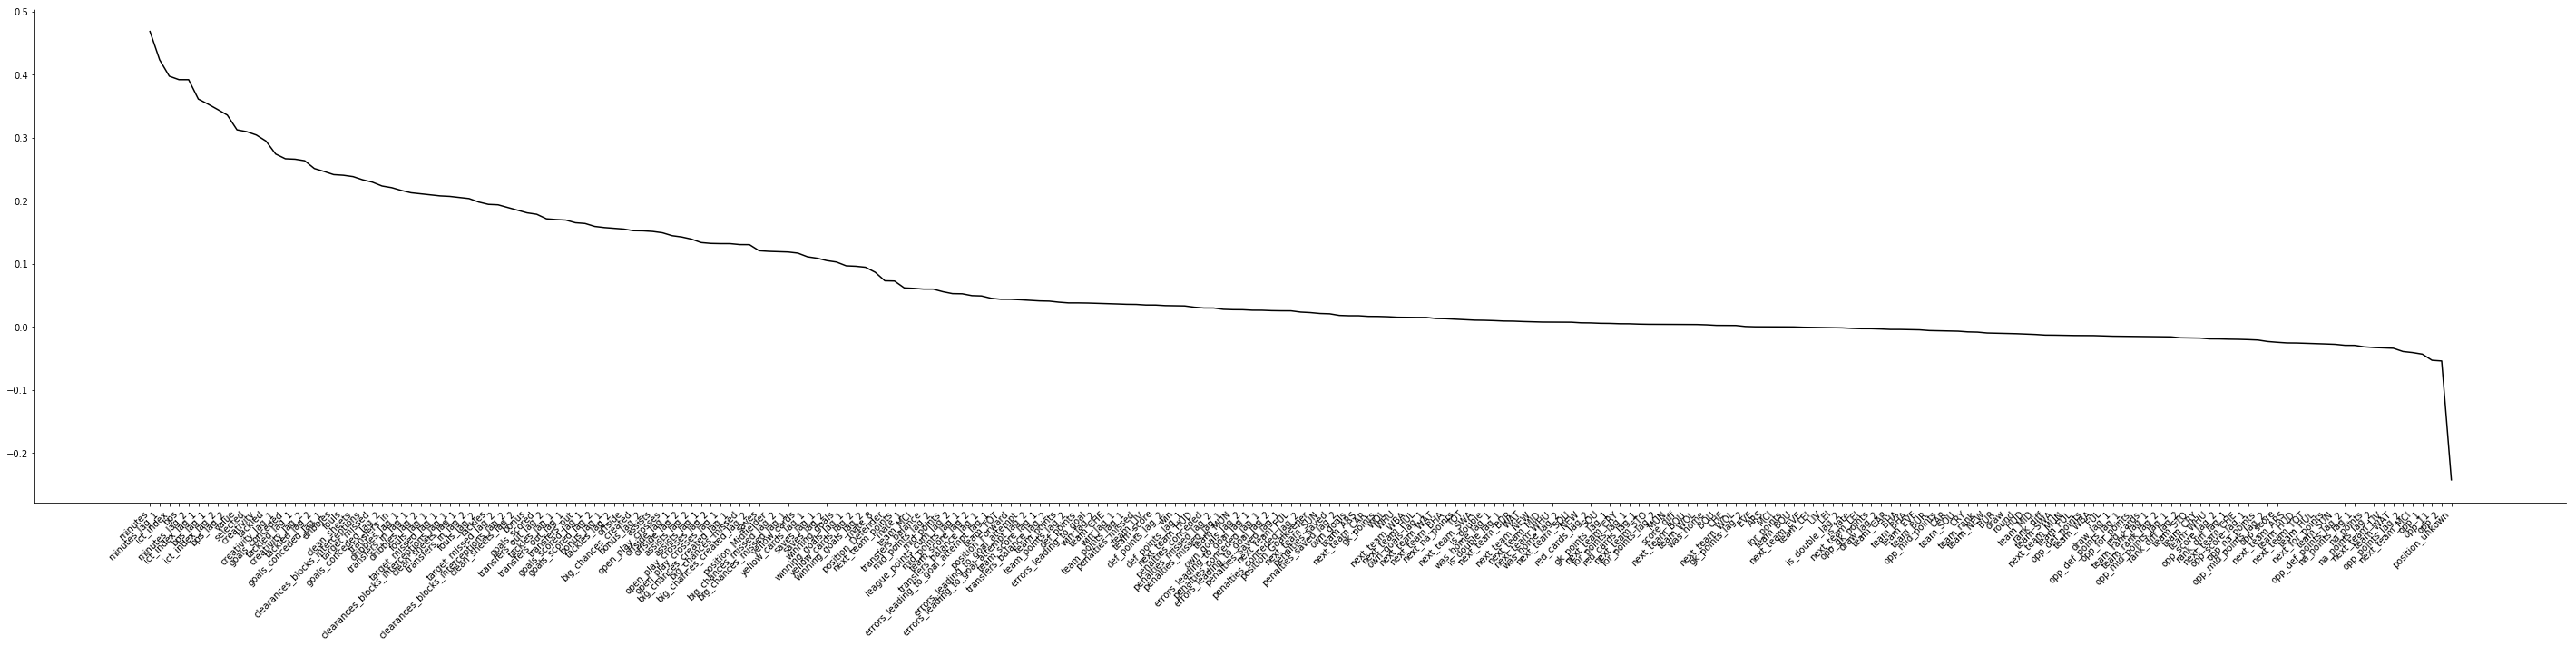

In [401]:
fig,ax=plt.subplots(figsize=(50,10))
sns.lineplot(data=target_corr.sort_values(ascending=False),
            sort=False, color=axiscolour, ax=ax)

ax=color_axis(ax)

plt.xticks(rotation=45, ha='right')
plt.savefig('feature_target_corr.png', facecolor=facecolour)

I drop everything with a correlation with the target less than 0.05 correlation (magnitude).

In [402]:
to_drop=list(target_corr[(target_corr<0.05)
                         &(target_corr>-0.05)].index)

In [403]:
to_drop

['ARS',
 'BHA',
 'BOU',
 'BUR',
 'CAR',
 'CHE',
 'CRY',
 'EVE',
 'FUL',
 'HUD',
 'LEI',
 'LIV',
 'MCI',
 'MUN',
 'NEW',
 'SOU',
 'TOT',
 'WAT',
 'WHU',
 'WOL',
 'def_points',
 'def_points_lag_1',
 'def_points_lag_2',
 'draw',
 'draw_lag_1',
 'draw_lag_2',
 'errors_leading_to_goal',
 'errors_leading_to_goal_attempt',
 'errors_leading_to_goal_attempt_lag_1',
 'errors_leading_to_goal_attempt_lag_2',
 'errors_leading_to_goal_lag_1',
 'errors_leading_to_goal_lag_2',
 'for_points',
 'for_points_lag_1',
 'for_points_lag_2',
 'gk_points',
 'gk_points_lag_1',
 'gk_points_lag_2',
 'is_double',
 'is_double_lag_1',
 'is_double_lag_2',
 'is_late',
 'na_points',
 'na_points_lag_1',
 'na_points_lag_2',
 'opp_def_points',
 'opp_def_points_lag_1',
 'opp_def_points_lag_2',
 'opp_for_points',
 'opp_gk_points',
 'opp_mid_points',
 'opp_mid_points_lag_1',
 'opp_mid_points_lag_2',
 'opp_na_points',
 'opp_points_lag_2',
 'opp_score',
 'opp_score_lag_1',
 'opp_score_lag_2',
 'own_goals',
 'own_goals_lag_1',
 

In [404]:
data.drop(to_drop, axis=1, inplace=True)

In [405]:
data['adj_round']=time

In [406]:
data.shape

(63594, 90)

`position_unkown` (yes I know its mispelled), im going to drop this feature, not becuase its failed me in anyway but because its an artifact of the data collection stage that brings in forward information. If a player dropped out of the premier league during 2018/19 season and didnt distinguish themselves to identify their position during that time then they are classified as unkown. 

Off course only bad players that left the premier league (and so get even fewer points) will be classified as unkown, but to do so brings in forward information I would not know if I was to repeat this project for the 2019/20 season. 

In [407]:
data.drop('position_unkown',axis=1,inplace=True)

I now use RFECV on several different models.

In [408]:
class FootballPreprocessor(BaseEstimator, TransformerMixin):
    '''
    preprocessor class, dropsmissing, dummies, polynomials, assigns class to target,
    takes target out of dataset, gets coeficient names and makes the train test split
    
        target: str of target column
        to_drop: list of columns to drop
        to_dummy: list of columns to dummy
        test_size: testset as fraction as total dataset
        dropna: bool, True drops rows with np.nan values, default is True
        classify: bool, True uses the assign class function and stratifys the train test split
                  designed for processing data for classifiers
        threshold: int, if y>int return 1. used to create the classes in the target.
        poly: bool, True returns dataset with 2-degree polynomials of original dataset
              the coef_names are adjusted to fit the new number of features.
    '''
    def __init__(self, target, to_drop=None, to_dummy=None, test_size=0.3, dropna=True, classify=False, threshold=None, poly=False, time_split=False,when=77):
        self.to_drop=to_drop
        self.to_dummy=to_dummy
        self.test_size=test_size
        self.target=target
        self.dropna=dropna
        self.classify=classify
        self.threshold=threshold
        self.poly=poly
        self.time_split=time_split
        self.when=when
        
    def fill_missing_teams(self, X):
        '''
        fills missing values with 0
        for teams that cross from train to 
        test set but might not be in all seasons
        '''
        teams=['ARS', 'BOU', 'BHA', 'BUR', 'CHE', 'CRY', 'EVE','NEW',
        'HUD', 'LEI', 'LIV', 'MCI', 'MUN', 'SOU', 'TOT', 'WAT',
       'WHU']
        for team in teams:
            try:
                X[team]=X[team].fillna(value=0)
            except:
                continue
        return X
        
    def dropmissing(self, X):
        '''
        drops missing values, for the designed data set this will
        take out rows without lags. removing the first 2 weeks for
        each player and last.
        '''
        X.dropna(inplace=True)
        return X
        
    def get_target(self, X):
        '''
        pops out target creating a y series
        '''
        y=X.pop(self.target)
        return X,y
        
    def drop_me(self, X):
        '''
        drops any columns specified
        '''
        droping=self.to_drop
        X=X.drop(droping, axis=1)
        return X
    
    def dummy_me(self, X):
        '''
        dummies any columns specified if position
        or team so doesnt drop first as unkowns 
        and dropout teams will be force
        dropped later
        '''
        if ('position' in self.to_dummy) or ('team' in self.to_dummy):
            dummying = [col for col in self.to_dummy if (col!='position') and (col!='team')]
            X=pd.get_dummies(X,columns=dummying,drop_first=True)
            
            if 'position' in self.to_dummy:
                X=pd.get_dummies(X,columns=['position'])
                
            if 'team' in self.to_dummy:
                X=pd.get_dummies(X,columns=['team'])
        else:
            dummying=self.to_dummy
            X=pd.get_dummies(X,columns=dummying)
        return X
    
    def polyfi(self, X):
        '''
        creates the polynomial of the X features, also gets the coef names
        returns both. no keyword for more than 2 degrees
        '''
        poly=PolynomialFeatures()#2degrees
        coef_names=poly.fit(X).get_feature_names(X.columns)
        coef_names=[col.replace(' ', '_x_') for col in coef_names]
        X=poly.fit_transform(X)
        X=pd.DataFrame(X,columns=coef_names)
        return X
    
    def assign_class(self, row):
        '''
        The .apply function used to classifiy the target
        '''
        if row > self.threshold:
            return 1
        else:
            return 0
        
    def create_class(self, y):
        '''
        function that employs the .apply function to classify y
        '''
        y = y.apply(self.assign_class)
        return y
    
    def get_coef_names(self, X):
        '''
        gets coef names for X features
        '''
        return X.columns
    
    def train_test(self, X, y):
        '''
        makes train test split, if classify == True then uses stratify.
        '''
        if self.classify==True:
            return train_test_split(X,y,test_size=self.test_size,stratify=y,random_state=1)
        else:
            return train_test_split(X,y,test_size=self.test_size)
    
    def make_time_split(self, X, y):
        '''
        default=adj_round 77
        makes the test set the 2018/19 season
        the train set is the 2016/17 and 2017/18 season
        '''
        
        print('X', X.shape)
        
        X_test = X[X['adj_round']>=self.when]
        print('X_test',X_test.shape)
        X_train = X[X['adj_round']<self.when]
        print('X_train',X_train.shape)
        train_loc = list(X_train.index)
        test_loc = list(X_test.index)
        y_train = y.loc[train_loc]
        y_test = y.loc[test_loc]
        
        X_train=X_train.drop('adj_round', axis=1)
        X_test=X_test.drop('adj_round', axis=1)
        
        return X_train, X_test, y_train, y_test
    
    def drop_unkowns(self, X):
        X = X.drop('position_unkown',axis=1)
        return X
    
    def clear_dummies(self, X):
        drop_dummies=['STO', 'FUL', 'SWA', 'MID', 
        'SUN', 'WOL', 'WBA', 'CAR', 'HUL','unkown']
        to_stay=X.columns
        
        for dum in drop_dummies:
            to_stay=[col for col in to_stay if dum not in col]
        
        to_drop=[col for col in X.columns if col not in to_stay]
        X=X.drop(to_drop,axis=1)
        return X
            
            
    
    def transform(self, X):
        '''
        channels different inputs to the right functions. 
        returns train test split data and the coef_names
        '''
        
        
        
        if self.to_drop != None:
            X=self.drop_me(X)
            
        if self.to_dummy != None:
            X=self.dummy_me(X)
            X=self.clear_dummies(X)
            
        X=self.fill_missing_teams(X)
        
        if self.dropna==True:
            X=self.dropmissing(X)
            
        X,y=self.get_target(X)
        
        if self.poly==True:
            X = self.polyfi(X)
            
        if self.classify == True:
            y=self.create_class(y)
        
        
            
        if self.time_split==False:
            X_train, X_test, y_train, y_test = self.train_test(X,y)
        else:
            X_train, X_test, y_train, y_test = self.make_time_split(X,y)
        
        coef_names=self.get_coef_names(X_train)
            
        return X_train, X_test, y_train, y_test, coef_names
    
    def fit(self, X):
        return self

In [409]:
data.isnull().sum().sum()

150984

These nulls come from the creation of lags and future variables, like team_next_week. To be usefull I need to drop the first 2 and last row of every player. 

In [410]:
proc=FootballPreprocessor(target='next_week_points', 
                          time_split=True)
X_train, X_test, y_train, y_test, coef_names = proc.transform(data)

X (57809, 88)
X_test (16860, 88)
X_train (40949, 88)


In [412]:
scaler = StandardScaler()

#take out team_MCI, position_Defender, position_Midfielder and
#position_unkown

dummies=['team_MCI','position_Defender',
         'position_Midfielder']

X_train_dum = X_train[dummies]
X_test_dum = X_test[dummies]

X_train.drop(dummies, axis=1, inplace=True)
X_test.drop(dummies, axis=1, inplace=True)

col_names = list(X_train.columns)
train_index=X_train.index
test_index=X_test.index

X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

X_train_ss = pd.DataFrame(X_train_ss, columns=col_names,
                         index=train_index)

X_test_ss = pd.DataFrame(X_test_ss, columns=col_names,
                         index=test_index)

X_train_ss=pd.concat([X_train_ss,X_train_dum],axis=1)
X_test_ss=pd.concat([X_test_ss,X_test_dum],axis=1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [413]:
print(X_train_ss.shape)
print(X_test_ss.shape)

(40949, 87)
(16860, 87)


In [414]:
lin_reg=LinearRegression()
selector=RFECV(lin_reg)

selector.fit(X_train_ss, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RFECV(cv='warn',
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [419]:
lin_cols=list(X_train_ss.loc[:,selector.support_].columns)

In [420]:
lin_cols

['clearances_blocks_interceptions',
 'clearances_blocks_interceptions_lag_2',
 'creativity',
 'ict_index',
 'ict_index_lag_1',
 'minutes',
 'minutes_lag_1',
 'minutes_lag_2',
 'saves',
 'selected',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'value',
 'opp_2',
 'team_MCI',
 'position_Defender',
 'position_Midfielder']

The final 18 features for Linear Regression Models

In [427]:
tree_reg=DecisionTreeRegressor(min_samples_split=30)
selector=RFECV(tree_reg,n_jobs=3)

selector.fit(X_train_ss, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RFECV(cv='warn',
   estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=30, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
   min_features_to_select=1, n_jobs=3, scoring=None, step=1, verbose=0)

In [428]:
tree_cols=list(X_train_ss.loc[:,selector.support_].columns)

In [430]:
tree_cols

['minutes', 'selected', 'transfers_in', 'transfers_out_lag_1']

Seems very small so I try the same with a Random Forest Regression, hopefully this will reveal some more usefull features.

In [431]:
from sklearn.ensemble import RandomForestRegressor

forest_reg=RandomForestRegressor(n_estimators=300,n_jobs=3)
selector=RFECV(forest_reg)

selector.fit(X_train_ss,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RFECV(cv='warn',
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [432]:
forest_cols=list(X_train_ss.loc[:,selector.support_].columns)

In [433]:
forest_cols

['big_chances_created',
 'big_chances_created_lag_1',
 'big_chances_created_lag_2',
 'big_chances_missed',
 'big_chances_missed_lag_2',
 'bonus',
 'bonus_lag_1',
 'bps',
 'bps_lag_1',
 'bps_lag_2',
 'clearances_blocks_interceptions',
 'clearances_blocks_interceptions_lag_1',
 'clearances_blocks_interceptions_lag_2',
 'creativity',
 'creativity_lag_1',
 'creativity_lag_2',
 'dribbles',
 'dribbles_lag_1',
 'dribbles_lag_2',
 'fouls',
 'fouls_lag_1',
 'fouls_lag_2',
 'goals_conceded',
 'goals_conceded_lag_1',
 'goals_conceded_lag_2',
 'ict_index',
 'ict_index_lag_1',
 'ict_index_lag_2',
 'league_points_cum_lag_2',
 'mid_points',
 'mid_points_lag_1',
 'mid_points_lag_2',
 'minutes',
 'minutes_lag_1',
 'minutes_lag_2',
 'offside',
 'offside_lag_1',
 'offside_lag_2',
 'open_play_crosses',
 'open_play_crosses_lag_1',
 'open_play_crosses_lag_2',
 'saves',
 'saves_lag_2',
 'selected',
 'tackled',
 'tackled_lag_1',
 'tackled_lag_2',
 'tackles',
 'tackles_lag_1',
 'tackles_lag_2',
 'target_missed

In [436]:
len(forest_cols)

68

In [441]:
svm_reg_lin=SVR(kernel='linear')

In [442]:
selector=RFECV(svm_reg_lin,n_jobs=3)
selector.fit(X_train_ss,y_train)
svr_lin_cols=list(X_train_ss.loc[:,selector.support_].columns)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [446]:
svr_lin_cols

['assists',
 'assists_lag_1',
 'assists_lag_2',
 'big_chances_created',
 'big_chances_created_lag_1',
 'big_chances_created_lag_2',
 'big_chances_missed',
 'big_chances_missed_lag_1',
 'big_chances_missed_lag_2',
 'bonus',
 'bonus_lag_1',
 'bonus_lag_2',
 'bps',
 'bps_lag_1',
 'bps_lag_2',
 'clean_sheets',
 'clean_sheets_lag_1',
 'clean_sheets_lag_2',
 'clearances_blocks_interceptions',
 'clearances_blocks_interceptions_lag_1',
 'clearances_blocks_interceptions_lag_2',
 'creativity',
 'creativity_lag_1',
 'creativity_lag_2',
 'dribbles',
 'dribbles_lag_1',
 'dribbles_lag_2',
 'fouls_lag_1',
 'fouls_lag_2',
 'goals_conceded',
 'goals_conceded_lag_1',
 'goals_conceded_lag_2',
 'goals_scored',
 'goals_scored_lag_1',
 'goals_scored_lag_2',
 'ict_index',
 'ict_index_lag_1',
 'ict_index_lag_2',
 'mid_points',
 'mid_points_lag_1',
 'mid_points_lag_2',
 'minutes',
 'minutes_lag_1',
 'minutes_lag_2',
 'offside',
 'offside_lag_2',
 'open_play_crosses',
 'open_play_crosses_lag_1',
 'open_play_cro

In [480]:
len(svr_lin_cols)

83

In [466]:
lin_cols.append('next_week_points')
forest_cols.append('next_week_points')
svr_lin_cols.append('next_week_points')

In [469]:
data=pd.read_csv('final_dataset.csv', low_memory=False)

In [472]:
data=pd.get_dummies(data, columns=['team', 'next_team', 'position'])

In [473]:
lin_data=data[lin_cols]

In [474]:
tree_data=data[forest_cols]

In [475]:
svm_data=data[svr_lin_cols]

In [477]:
lin_data['adj_round']=time
tree_data['adj_round']=time
svm_data['adj_round']=time

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [479]:
lin_data.to_csv('linear_data.csv')
tree_data.to_csv('tree_data.csv')
svm_data.to_csv('svm_data.csv')